# Classify B-ALL

- After every kernel restart rerun "Core"
- It's best to restart after you run a training process

## Core (Always run)

Imports

In [142]:
# import cudf
# import cuml
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time
import random

import shap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.utils import shuffle, resample
from xgboost import XGBClassifier, DMatrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Global Variables

In [ ]:
start_time = time.time()

path_to_data = "data/"

### Preprocess

Load Datasets

In [4]:
df_healthy = pd.read_csv("data/merged_unstranded_healthy_data.csv", index_col='gene_id') # Sample names is column
df_aml = pd.read_csv("data/merged_unstranded_unhealthy_data.csv", index_col='gene_id') # Sample names is column

In [5]:
df_aml.head()

,gene_name,gene_type,a9e276bb-593a-4723-b9b9-629618a0c657,15c888bd-e07c-4505-a65e-5619702f36f5,6f7ee2c2-8ee0-40f9-8ef3-0d389aa22a54,7c1f22be-3f25-4ac5-afe8-309341e3eeef,b8a5bb08-82db-48bd-9a4e-f3f5e6da4ba1,11d0511e-bf46-4a01-8280-aeef2d500047,cf1e67b9-5b7a-4db8-b0ad-3748c94802d0,90543510-306c-4183-942e-7567517ed18c,...,795bd9a1-27fa-4985-9b5e-a0cc6dd05128,8a9a769a-3c42-44a0-a593-28568dd28c55,3d3d26ee-5254-4cf0-b432-3cda8943bd01,57c32bde-c1a4-445e-862e-87273b773f8e,82517caf-7049-4524-911d-e497dcbd9e3d,4b7e2f66-53ee-4578-8b42-5c89c456dfb1,905b5922-dfd0-4e49-babb-a7150b2b2d15,54b3ce4b-fd3d-48ec-a745-c74b660daf4b,8e5a3caf-28eb-4ea7-ba86-1927734b4e24,22c31fec-434a-497c-b9d8-dcbe5b656b67
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,TSPAN6,protein_coding,0.5112,0.1393,0.3135,0.3545,0.3375,0.9980,0.1178,0.0647,...,0.5427,0.3932,0.4878,0.1025,0.4277,0.1683,0.6575,0.2247,0.1304,0.2045
ENSG00000000005,TNMD,protein_coding,0.0000,0.0389,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0929,0.0000,0.0000,0.0000,0.0000,0.1225,0.0000,0.0890,0.0000
ENSG00000000419,DPM1,protein_coding,40.7959,36.9689,33.8329,46.2597,29.8088,46.9932,26.4041,25.2849,...,49.0795,30.9708,22.3828,32.4526,53.3264,47.3646,61.9196,48.8084,31.3054,30.0885
ENSG00000000457,SCYL3,protein_coding,4.8853,3.3040,2.2476,3.0761,2.2452,6.3353,3.4748,4.4446,...,4.8340,2.5810,3.3498,5.3194,6.1770,4.1737,4.3328,3.2281,2.4823,3.3988
ENSG00000000460,C1orf112,protein_coding,2.7968,3.0878,5.3636,3.7860,4.3597,12.2108,6.0044,0.8848,...,2.9396,5.7676,3.2964,5.3151,2.7978,3.9167,4.0720,2.2194,4.2268,3.0527


#### Merging

In [144]:
# df_b_all = cudf.read_parquet(f"{path_to_data}B_ALL.pq") # Sample names is column
# df_b_all_healthy = cudf.read_parquet(f"{path_to_data}B_ALL_healthy.pq") # Sample names is column
# df_mixed_all = cudf.read_parquet(f"{path_to_data}ALL.pq") # Sample names is column
# df_aml_all = cudf.read_parquet(f"{path_to_data}AML.pq") # Sample names is column

b_all_length = len(df_healthy.columns.drop(['gene_name', 'gene_type']))  # Exclude non-numeric columns
b_all_healthy_length = len(df_aml.columns.drop(['gene_name', 'gene_type']))  # Exclude non-numeric columns
# mixed_all_length = len(df_mixed_all.columns.drop(['gene_name', 'gene_type']))  # Exclude non-numeric columns
# aml_all_length = len(df_aml_all.columns.drop(['gene_name', 'gene_type']))  # Exclude non-numeric columns
# total_length = b_all_length + mixed_all_length + aml_all_length
# total_length = b_all_length + mixed_all_length
total_length = b_all_length + b_all_healthy_length

print("B-ALL length:", len(df_healthy))
print("B-ALL Healthy length:", len(df_aml))

df_b_all_filtered = df_healthy #[df_healthy['gene_type'] == 'protein_coding']  # Filter for protein-coding genes
df_b_all_healthy_filtered = df_aml #[df_aml['gene_type'] == 'protein_coding']  # Filter for protein-coding genes

print("Filtered B-ALL length:", len(df_b_all_filtered))
print("Filtered B-ALL Healthy length:", len(df_b_all_healthy_filtered))

df_b_all_filtered = df_b_all_filtered.drop(['gene_name', 'gene_type'], axis=1)  # Drop non-numeric columns
df_b_all_healthy_filtered = df_b_all_healthy_filtered.drop(['gene_name', 'gene_type'], axis=1)  # Drop non-numeric columns

df_b_all_filtered = df_b_all_filtered.fillna(0).select_dtypes(include='number').T
df_b_all_healthy_filtered = df_b_all_healthy_filtered.fillna(0).select_dtypes(include='number').T

# df_b_all_filtered.head()

combined_df = pd.concat([df_b_all_filtered, df_b_all_healthy_filtered], axis=0)

# combined_df.tail()

combined_df['condition'] = [1] * len(df_b_all_healthy_filtered) + [0] * len(df_b_all_filtered)

# combined_df.head()

if (len(df_b_all_filtered) + len(df_b_all_healthy_filtered)) != combined_df.shape[0]:
    print(f"Expected number of rows: {len(df_b_all_filtered) + len(df_b_all_healthy_filtered)}, Actual number of rows: {combined_df.shape[0]}")
    raise ValueError("The number of rows in the combined DataFrame does not match the sum of B-ALL and B-ALL Healthy lengths.")

# merged_df = df_b_all.merge(df_mixed_all, on='gene_id', how='inner')
# merged_df = merged_df.merge(df_aml_all, on='gene_id', how='inner')

# merged_df = merged_df[merged_df['gene_type'] == 'protein_coding']  # Filter for protein-coding genes

# gene_names = merged_df['gene_name_x']

# merged_df_transposed = merged_df.fillna(0)  # Fill NaN values with 0
# merged_df_transposed = merged_df.select_dtypes(include='number').T

# if total_length != merged_df_transposed.shape[0]:
#     print(f"Expected number of rows: {total_length}, Actual number of rows: {merged_df_transposed.shape[0]}")
#     raise ValueError("The number of rows in the merged DataFrame does not match the sum of B-ALL and mixed ALL lengths.")

B-ALL length: 60660
B-ALL Healthy length: 60660
Filtered B-ALL length: 60660
Filtered B-ALL Healthy length: 60660


In [146]:
# Rename column gene_id to sample_id
# combined_df = combined_df.rename_axis('gene_id').reset_index()


# combined_df = combined_df['gene_id'].rename('sample_id', inplace=True)

combined_df

combined_df.to_csv("data/merged_unstranded_combined_data.csv")

In [9]:
# combined_df = combined_df.to_pandas()  # Convert to pandas DataFrame for further processing

print(f"Amount of features in the merged DataFrame: {combined_df.shape[1]}")

Amount of features in the merged DataFrame: 19963


In [ ]:
# merged_df_transposed = merged_df_transposed.to_pandas()

# gene_names = gene_names.to_pandas().reset_index(drop=True)

# print(f"Amount of features in the merged DataFrame: {merged_df_transposed.shape[1]}")

## XGBoost (Single Test Split)

PU Labeling

In [124]:
# y = pd.Series([1] * b_all_length + [0] * (mixed_all_length + aml_all_length), index=merged_df_transposed.index)

# y = combined_df['condition']  # Use the 'condition' column as the target variable

# y = pd.Series([1] * b_all_length + [0] * (mixed_all_length), index=merged_df_transposed.index)

# Loadd metadata
healthy_metadata = pd.read_csv("data/healthy_aml_metadata.csv", index_col='uuid')
unhealthy_metadata = pd.read_csv("data/unhealthy_aml_metadata.csv", index_col='uuid')

# Combine metadata
metadata = pd.concat([healthy_metadata, unhealthy_metadata], axis=0)
# Filter metadata to match the samples in combined_df
# metadata = metadata[metadata.index.isin(combined_df.columns)]

# Ensure the index is reset and matches the combined_df columns
metadata = metadata.drop(columns='workflow_version')

# sort metadata to match the order of combined_df columns
metadata = metadata.reindex(combined_df.index)

metadata.head()
# Transform condition healthy to 0 and unhealthy to 1
y = metadata['condition'].replace({'healthy': 0, 'unhealthy': 1})

y = y.dropna()  # Drop NaN values from y

# drops 1 from y. need to ensure combined_df drops the same sample
combined_df = combined_df.loc[y.index]  # Align combined_df with y

/var/folders/6s/mwqhy3lx4sz4vx_y7pvbvsdw0000gn/T/ipykernel_8323/369386104.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = metadata['condition'].replace({'healthy': 0, 'unhealthy': 1})


In [125]:
y

c69538be-27a1-4949-b04b-5386e4102386    0.0
8a594674-acc2-40b1-bb50-80d103a9e50a    0.0
db3fc680-b411-42af-8845-8dd1732815ea    0.0
ee083116-281e-406c-bdd5-b425f5d2eab0    0.0
61547668-0038-4e0e-978d-80bfc6307249    0.0
                                       ... 
4b7e2f66-53ee-4578-8b42-5c89c456dfb1    1.0
905b5922-dfd0-4e49-babb-a7150b2b2d15    1.0
54b3ce4b-fd3d-48ec-a745-c74b660daf4b    1.0
8e5a3caf-28eb-4ea7-ba86-1927734b4e24    1.0
22c31fec-434a-497c-b9d8-dcbe5b656b67    1.0
Name: condition, Length: 441, dtype: float64

Sanity Check

In [127]:
merged_df_normalized = np.log2(combined_df + 1)  # Log2 transformation

# merged_df_normalized = np.log2(merged_df_transposed + 1)  # Log2 transformation

In [108]:
merged_df_normalized

gene_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288654,ENSG00000288656,ENSG00000288658,ENSG00000288660,ENSG00000288661,ENSG00000288669,ENSG00000288671,ENSG00000288674,ENSG00000288675,condition
c69538be-27a1-4949-b04b-5386e4102386,0.237074,0.000000,5.363974,3.090396,3.403036,8.519165,1.031677,3.720541,4.629188,5.315327,...,0.0,0.042224,0.055196,2.220980,0.0,0.041243,0.0,0.148348,1.290955,1.0
8a594674-acc2-40b1-bb50-80d103a9e50a,0.186374,0.000000,5.335966,3.389195,2.610251,8.614647,1.204266,4.242313,3.956205,4.918119,...,0.0,0.031254,0.106616,1.742825,0.0,0.000000,0.0,0.094912,0.910886,1.0
db3fc680-b411-42af-8845-8dd1732815ea,1.176897,0.086104,5.640728,2.917527,3.053042,8.335991,1.655443,4.680516,4.577816,5.482674,...,0.0,0.188907,0.280006,0.806778,0.0,0.032524,0.0,0.202888,0.767655,1.0
ee083116-281e-406c-bdd5-b425f5d2eab0,1.002667,0.099901,5.901434,3.157399,3.707083,7.481381,1.749191,4.566773,5.342882,5.845046,...,0.0,0.148869,0.050606,1.013998,0.0,0.000000,0.0,0.121679,0.588996,1.0
61547668-0038-4e0e-978d-80bfc6307249,1.042224,0.000000,5.741276,2.998972,3.229126,8.811886,1.882643,4.372144,4.858150,5.850934,...,0.0,0.126180,0.000000,1.153157,0.0,0.123401,0.0,0.151859,0.755828,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4b7e2f66-53ee-4578-8b42-5c89c456dfb1,0.224411,0.000000,5.595880,2.371196,2.297690,7.984639,0.665393,4.384485,5.075289,5.440411,...,0.0,0.000000,0.000000,1.570074,0.0,0.034075,0.0,0.237074,0.540523,0.0
905b5922-dfd0-4e49-babb-a7150b2b2d15,0.729009,0.166715,5.975438,2.414893,2.342555,7.030463,0.626299,5.014324,5.764325,5.012470,...,0.0,0.065434,0.314639,1.518334,0.0,0.000000,0.0,0.293370,0.853517,0.0
54b3ce4b-fd3d-48ec-a745-c74b660daf4b,0.292428,0.000000,5.638317,2.080009,1.686792,8.506401,0.298541,4.433694,3.526808,4.119813,...,0.0,0.073546,0.032665,2.156461,0.0,0.024320,0.0,0.154454,0.918234,0.0
8e5a3caf-28eb-4ea7-ba86-1927734b4e24,0.176833,0.123004,5.013703,1.800040,2.385928,9.136666,0.701150,4.503323,3.861439,5.510680,...,0.0,0.047818,0.235359,3.967473,0.0,0.023610,0.0,0.416516,0.769010,0.0


In [128]:
assert merged_df_normalized.shape[0] == len(y), "Mismatch: number of samples in X and labels in y"
assert merged_df_normalized.index.equals(y.index), "Mismatch: index order between X and y"

In [117]:
# unique values in y
print("Unique values in y:", y.unique())

y = y.dropna()  # Drop NaN values from y

Unique values in y: [ 0.  1. nan]


c69538be-27a1-4949-b04b-5386e4102386    0.0
8a594674-acc2-40b1-bb50-80d103a9e50a    0.0
db3fc680-b411-42af-8845-8dd1732815ea    0.0
ee083116-281e-406c-bdd5-b425f5d2eab0    0.0
61547668-0038-4e0e-978d-80bfc6307249    0.0
                                       ... 
4b7e2f66-53ee-4578-8b42-5c89c456dfb1    1.0
905b5922-dfd0-4e49-babb-a7150b2b2d15    1.0
54b3ce4b-fd3d-48ec-a745-c74b660daf4b    1.0
8e5a3caf-28eb-4ea7-ba86-1927734b4e24    1.0
22c31fec-434a-497c-b9d8-dcbe5b656b67    1.0
Name: condition, Length: 441, dtype: float64

Label shuffle

In [ ]:
# y = y.sample(frac=1, random_state=42).reset_index(drop=True)

Log2 Normalizing

In [75]:
# Check which samples are in your cleaned expression data
print("Samples in expression data:", merged_df_normalized.index[:5])
print("Samples in target variable:", y.index[:5])

# Option 1: If y is indexed by sample IDs (recommended)
# Keep only samples that exist in both datasets
common_samples = merged_df_normalized.index.intersection(y.index)
print(f"Common samples: {len(common_samples)}")

merged_df_normalized_aligned = merged_df_normalized.loc[common_samples]
y_aligned = y.loc[common_samples]

# Option 2: If y is a simple series without proper indexing
# Reset indices to match
if not y.index.equals(merged_df_normalized.index):
    print("Realigning indices...")
    # Assuming y should be indexed by sample IDs
    y.index = merged_df_normalized.index

# Remove NaN values from both simultaneously
valid_mask = ~(y.isna() | merged_df_normalized.isna().any(axis=1))
merged_df_normalized_clean = merged_df_normalized[valid_mask]
y_clean = y[valid_mask]

print(f"After alignment: X shape {merged_df_normalized_clean.shape}, y length {len(y_clean)}")
print(f"NaN in y: {y_clean.isna().sum()}")

# Continue with your preprocessing
merged_df_normalized_clean = merged_df_normalized_clean.select_dtypes(include='number')
merged_df_normalized_clean = merged_df_normalized_clean.fillna(0)

Samples in expression data: Index(['c69538be-27a1-4949-b04b-5386e4102386',
       '8a594674-acc2-40b1-bb50-80d103a9e50a',
       'db3fc680-b411-42af-8845-8dd1732815ea',
       'ee083116-281e-406c-bdd5-b425f5d2eab0',
       '61547668-0038-4e0e-978d-80bfc6307249'],
      dtype='object')
Samples in target variable: Index(['c69538be-27a1-4949-b04b-5386e4102386',
       '8a594674-acc2-40b1-bb50-80d103a9e50a',
       'db3fc680-b411-42af-8845-8dd1732815ea',
       'ee083116-281e-406c-bdd5-b425f5d2eab0',
       '61547668-0038-4e0e-978d-80bfc6307249'],
      dtype='object')
Common samples: 442
After alignment: X shape (441, 19963), y length 441
NaN in y: 0


In [52]:
# Drop non-numeric columns
merged_df_normalized = merged_df_normalized.select_dtypes(include='number')

# Drop Nan values
merged_df_normalized = merged_df_normalized.fillna(0)

In [93]:
merged_df_normalized

gene_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288654,ENSG00000288656,ENSG00000288658,ENSG00000288660,ENSG00000288661,ENSG00000288669,ENSG00000288671,ENSG00000288674,ENSG00000288675,condition


In [92]:
y_aligned

c69538be-27a1-4949-b04b-5386e4102386    0.0
8a594674-acc2-40b1-bb50-80d103a9e50a    0.0
db3fc680-b411-42af-8845-8dd1732815ea    0.0
ee083116-281e-406c-bdd5-b425f5d2eab0    0.0
61547668-0038-4e0e-978d-80bfc6307249    0.0
                                       ... 
4b7e2f66-53ee-4578-8b42-5c89c456dfb1    1.0
905b5922-dfd0-4e49-babb-a7150b2b2d15    1.0
54b3ce4b-fd3d-48ec-a745-c74b660daf4b    1.0
8e5a3caf-28eb-4ea7-ba86-1927734b4e24    1.0
22c31fec-434a-497c-b9d8-dcbe5b656b67    1.0
Name: condition, Length: 442, dtype: float64

In [98]:
# Remove NaN values from y and align with expression data
print(f"Before cleaning: y shape {len(y)}, NaN count: {y.isna().sum()}")

# Drop NaN values from y and corresponding rows from X
valid_mask = ~y.isna()
y_clean = y[valid_mask]
merged_df_normalized_clean = merged_df_normalized[valid_mask]

print(f"After cleaning: y shape {len(y_clean)}, X shape {merged_df_normalized_clean.shape}")
print(f"y unique values: {y_clean.unique()}")
print(f"NaN in clean y: {y_clean.isna().sum()}")

# Convert to integer for cleaner labels
y_clean = y_clean.astype(int)
print(f"Final y dtype: {y_clean.dtype}")
print(f"Final y unique values: {y_clean.unique()}")

# Now do train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    merged_df_normalized_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print(f"Final shapes - X_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Class distribution - train: {np.bincount(y_train)}, test: {np.bincount(y_test)}")

Before cleaning: y shape 442, NaN count: 1
After cleaning: y shape 441, X shape (0, 19963)
y unique values: [0. 1.]
NaN in clean y: 0
Final y dtype: int64
Final y unique values: [0 1]


/var/folders/6s/mwqhy3lx4sz4vx_y7pvbvsdw0000gn/T/ipykernel_8323/3737810476.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_df_normalized_clean = merged_df_normalized[valid_mask]


ValueError: Found input variables with inconsistent numbers of samples: [0, 441]

Train Test Split

In [129]:
# merged_df_normalized, y = shuffle(merged_df_normalized, y, random_state=42)

# merged_df_normalized.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(
    merged_df_normalized, y, test_size=0.2, random_state=42, stratify=y
)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Undersampler and oversampler

In [131]:
rus = RandomUnderSampler(sampling_strategy={1: 200}, random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)

smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

Scaler

In [132]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Noise

In [ ]:
# noise = np.random.normal(0, 0.8, x_train.shape) * x_train

# x_train += noise

Variance Threshold (Remove constants)

In [133]:
selector_vt = VarianceThreshold(threshold=0.0)

x_train = selector_vt.fit_transform(x_train)
x_test = selector_vt.transform(x_test)

PCA

In [ ]:
# selector = PCA(n_components=0.95, random_state=42)
# x_train = selector.fit_transform(x_noisy)
# x_test = selector.transform(x_test)

SelectKBest

In [134]:
selector = SelectKBest(score_func=f_classif, k=500)
x_train = selector.fit_transform(x_train, y_train)
x_test = selector.transform(x_test)

In [ ]:
# train_fac = 0.1

# x_train, y_train = resample(
#     x_train, y_train, 
#     replace=False, 
#     n_samples=int(len(x_train) * train_fac),
#     stratify=y_train,
#     random_state=42
# )

# print(x_train.shape)

In [ ]:
# gene_names_worst = gene_names.iloc[mixed_indices].reset_index(drop=True)

# gene_names = gene_names[selector.get_support(indices=True)].reset_index(drop=True)

Random features

In [ ]:
# n_train, n_features = x_noisy.shape
# n_test = x_test.shape[0]

# x_train = np.random.normal(0, 1, size=(n_train, n_features))
# x_test = np.random.normal(0, 1, size=(n_test, n_features))

In [135]:
print(f"Shape of x_train after feature selection: {x_train.shape}"
      f", Shape of x_test: {x_test.shape}")

Shape of x_train after feature selection: (400, 500), Shape of x_test: (89, 500)


In [136]:
if x_train.shape[0] != y_train.shape[0] or x_test.shape[0] != y_test.shape[0]:
    raise ValueError("Mismatch: number of samples in X_train/X_test and labels in y_train/y_test")

if sum(y_train == 1) == 0 or sum(y_train == 0) == 0:
    raise ValueError("Training set must contain both classes (B-ALL and non-B-ALL).")

if isinstance(y_train, pd.DataFrame) or isinstance(y_test, pd.DataFrame):
    raise ValueError("y_train and y_test must be Series, not DataFrames.")

Logistic Regression

In [138]:
lr = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

lr.fit(x_train, y_train)

y_proba = lr.predict_proba(x_test)[:, 1]

auc_score = roc_auc_score(y_test, y_proba)

print(f"AUC: {auc_score:.3f}")

AUC: 1.000


XGBClassifier

In [ ]:
# scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# xgb = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="auc",
#     use_label_encoder=False,
#     # scale_pos_weight=scale_pos_weight,  # Keep this for class imbalance
#     tree_method="hist",
#     device="cuda",
    
#     # Core parameters
#     n_estimators=500,        # More trees, let early stopping decide
#     learning_rate=0.05,      # Moderate learning rate
#     max_depth=4,             # Allow some complexity for gene interactions
    
#     # Regularization (important for high-dimensional genomics)
#     reg_lambda=5.0,          # L2 regularization
#     reg_alpha=1.0,           # L1 regularization (feature selection)
    
#     # Sampling (reduces overfitting)
#     subsample=0.8,           # Sample 80% of rows
#     colsample_bytree=0.8,    # Sample 80% of features per tree
#     colsample_bylevel=0.8,   # Additional feature sampling
    
#     # Early stopping
#     early_stopping_rounds=50,  # Stop if no improvement
    
#     # Reproducibility
#     random_state=42
# )

# xgb = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="auc",
#     use_label_encoder=False,
#     tree_method="hist",
#     device="cuda",
    
#     # Reduced model complexity
#     n_estimators=50,          # Much fewer trees (was 500)
#     learning_rate=0.3,        # Higher learning rate for faster, less precise learning
#     max_depth=2,              # Shallow trees (was 4)
    
#     # Increased regularization
#     reg_lambda=20.0,          # Much higher L2 regularization (was 5.0)
#     reg_alpha=10.0,           # Higher L1 regularization (was 1.0)
    
#     # More aggressive sampling
#     subsample=0.5,            # Sample only 50% of rows (was 0.8)
#     colsample_bytree=0.5,     # Sample only 50% of features per tree (was 0.8)
#     colsample_bylevel=0.5,    # More aggressive feature sampling (was 0.8)
    
#     # Early stopping (keep as is)
#     early_stopping_rounds=20, # Stop earlier (was 50)
    
#     # Reproducibility
#     random_state=42
# )

# xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=True)

# gpu_x_test = DMatrix(x_test, y_test)

# y_pred = xgb.get_booster().predict(gpu_x_test)

# y_proba = xgb.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class

# auc_score = roc_auc_score(y_test, y_proba)

# print(f"AUC: {auc_score:.3f}")

### Statistics and Plots

Check seperator genes

(400, 500)


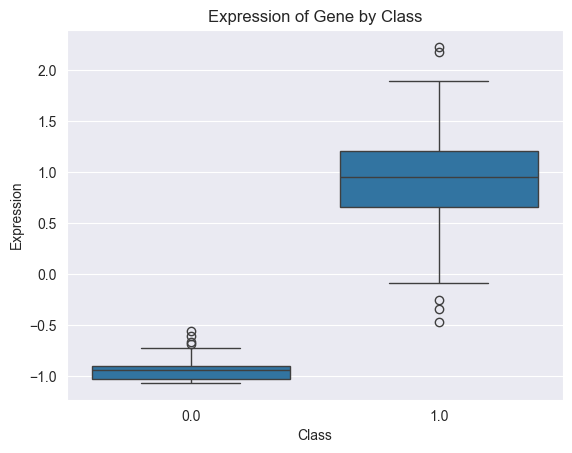

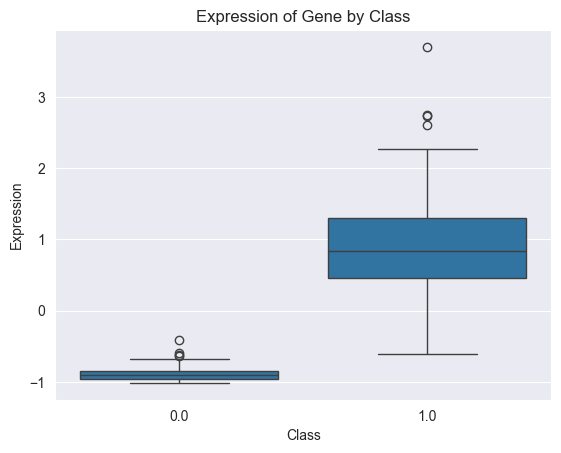

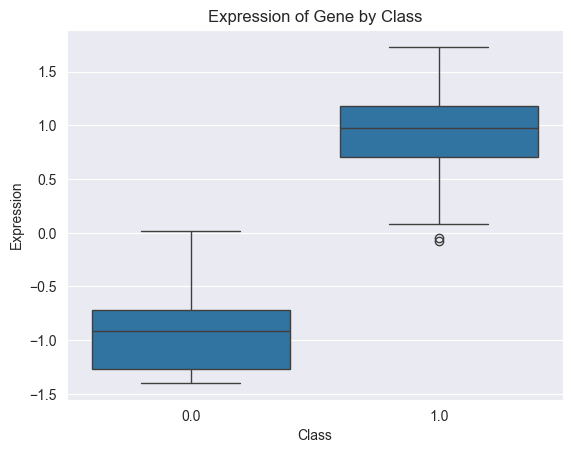

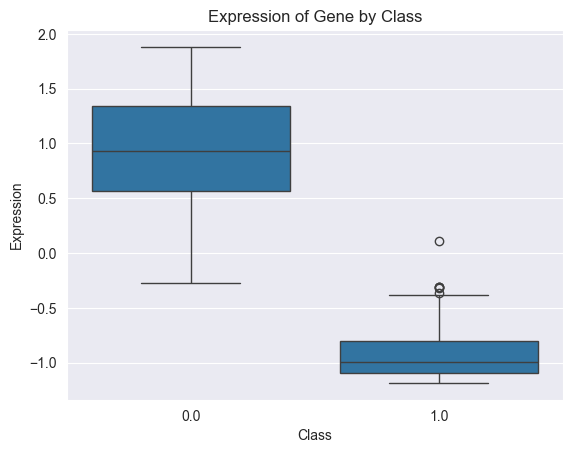

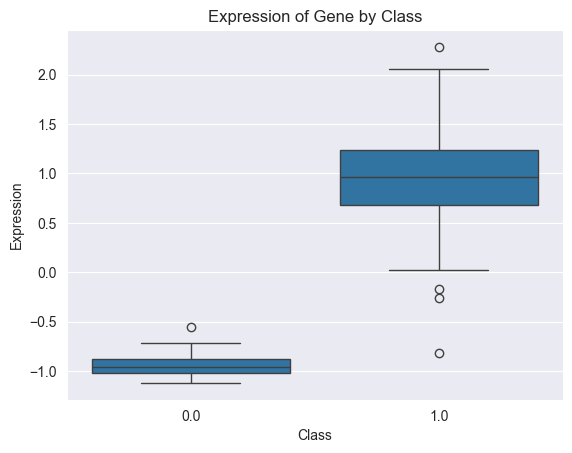

In [139]:
print(x_train.shape)

gene_aucs = []

for i in range(x_train.shape[1]):
    gene_values = x_train[:, i]
    try:
        auc_value = roc_auc_score(y_train, gene_values)
        gene_aucs.append((i, auc_value))
    except ValueError:
        continue

gene_aucs = np.array(gene_aucs, dtype=[('index', int), ('auc', float)])

gene_aucs_df = pd.DataFrame({
    "gene": gene_aucs['index'],
    "auc": gene_aucs['auc']
})
gene_aucs_df["auc_diff"] = abs(gene_aucs_df["auc"] - 0.5)  # How far from random
gene_aucs_df = gene_aucs_df.sort_values("auc_diff", ascending=False)

top_genes = gene_aucs_df.head(5)['gene'].astype(int).tolist()

for i in top_genes[:5]:  # visualize top 5 for example
    # Create a DataFrame manually
    df_plot = pd.DataFrame({
        'Expression': x_train[:, i],
        'Class': y_train
    })
    sns.boxplot(data=df_plot, x='Class', y='Expression')
    plt.title(f'Expression of Gene by Class')
    plt.show()

Plot Prediction Score Distributions

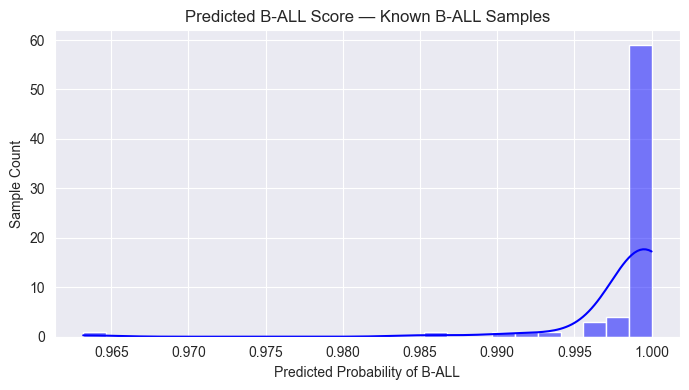

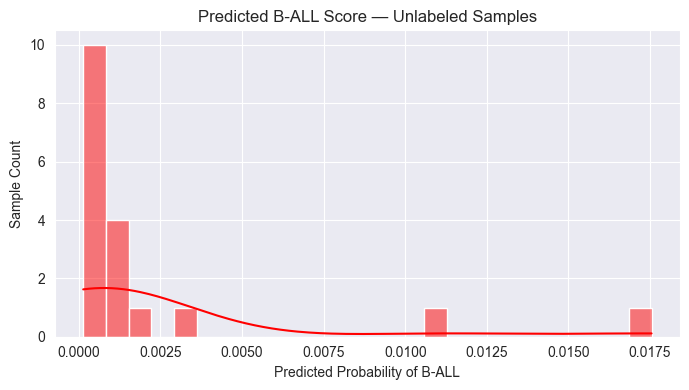

In [140]:
# Wrap predictions into a DataFrame for easier slicing
df_scores = pd.DataFrame({
    "B_ALL_score": y_proba,
    "Label": y_test  # ensure matching index
})

# Plot for known B-ALL (positives)
plt.figure(figsize=(7, 4))
sns.histplot(df_scores[df_scores["Label"] == 1]["B_ALL_score"], color="blue", bins=25, kde=True)
plt.title("Predicted B-ALL Score — Known B-ALL Samples")
plt.xlabel("Predicted Probability of B-ALL")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

# Plot for unlabeled/mixed
plt.figure(figsize=(7, 4))
sns.histplot(df_scores[df_scores["Label"] == 0]["B_ALL_score"], color="red", bins=25, kde=True)
plt.title("Predicted B-ALL Score — Unlabeled Samples")
plt.xlabel("Predicted Probability of B-ALL")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

Precision recall curve

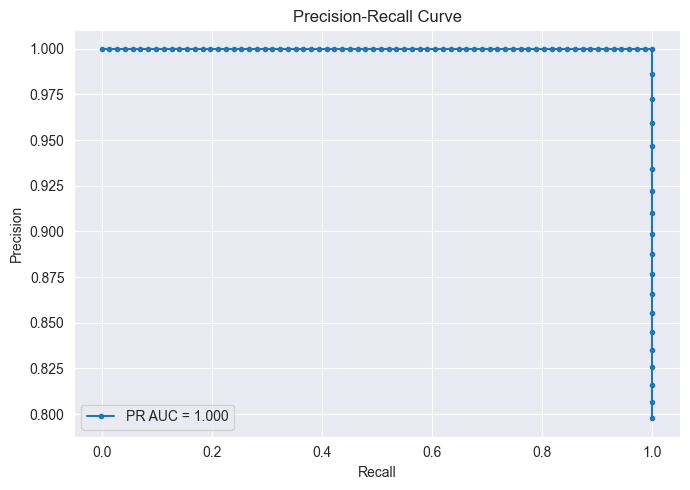

In [141]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SHAP

In [ ]:
# x_test_named = pd.DataFrame(x_test, columns=gene_names)

# x_test_named.head()

# Use the actual gene names directly
# explainer = shap.TreeExplainer(xgb)
explainer = shap.LinearExplainer(lr, x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test, 
                  plot_type="violin", 
                  max_display=20)

In [ ]:
shap.summary_plot(shap_values, x_test, plot_type="bar", max_display=20)

## XGBoost (Stratified KFold)

### Preprocessing

#### PU Labeling

In [ ]:
y = pd.Series([1] * b_all_length + [0] * (mixed_all_length), index=merged_df_transposed.index)

#### Sanity Check

In [ ]:
assert merged_df_transposed.shape[0] == len(y), "Mismatch: number of samples in X and labels in y"
assert merged_df_transposed.index.equals(y.index), "Mismatch: index order between X and y"

### Training

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

x = merged_df_transposed

for fold, (train_index, val_index) in enumerate(skf.split(x, y)):
    print(f"Processing fold {fold + 1}...")

    x_train_fold, x_val_fold = x.iloc[train_index], x.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    x_train_fold = np.log2(x_train_fold + 1)  # Log2 transformation
    x_val_fold = np.log2(x_val_fold + 1)      # Log2 transformation

    scaler = StandardScaler()
    x_train_fold = scaler.fit_transform(x_train_fold)
    x_val_fold = scaler.transform(x_val_fold)

    selector = SelectKBest(score_func=f_classif, k=5)
    x_train_fold = selector.fit_transform(x_train_fold, y_train_fold)
    x_val_fold = selector.transform(x_val_fold)

    scale_pos_weight = sum(y_train_fold == 0) / sum(y_train_fold == 1)

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,  # Keep this for class imbalance
        tree_method="hist",
        # device="cuda",
        
        # Core parameters
        n_estimators=500,        # More trees, let early stopping decide
        learning_rate=0.05,      # Moderate learning rate
        max_depth=4,             # Allow some complexity for gene interactions
        
        # Regularization (important for high-dimensional genomics)
        reg_lambda=5.0,          # L2 regularization
        reg_alpha=1.0,           # L1 regularization (feature selection)
        
        # Sampling (reduces overfitting)
        subsample=0.8,           # Sample 80% of rows
        colsample_bytree=0.8,    # Sample 80% of features per tree
        colsample_bylevel=0.8,   # Additional feature sampling
        
        # Early stopping
        early_stopping_rounds=50,  # Stop if no improvement
        
        # Reproducibility
        random_state=42
    )

    xgb.fit(x_train_fold, y_train_fold, eval_set=[(x_val_fold, y_val_fold)], verbose=False)

    y_proba = xgb.predict_proba(x_val_fold)[:, 1]  # Get probabilities for the positive class

    auc_fold = roc_auc_score(y_val_fold, y_proba)

    auc_scores.append(auc_fold)

    print(f"Fold {fold + 1}, AUC: {auc_fold:.3f}")

print(f"Mean AUC across all folds: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")

### Statistics and Plots

In [ ]:
sns.histplot(auc_scores, kde=True, bins=5)
plt.title("Distribution of AUC Scores Across Folds")
plt.xlabel("AUC")
plt.ylabel("Number of Folds")
plt.axvline(np.mean(auc_scores), color="red", linestyle="--", label="Mean AUC")
plt.legend()
plt.show()